# 读取数据

In [11]:
import pickle
import numpy as np
import pandas as pd

geofile = pd.read_csv('../data/atom/TGESHD.geo')
geo_ids = list(geofile['geo_id'])

relfile = pd.read_csv('../data/atom/TGESHD.rel')
edge_name={}
for i in relfile['rel_id']:
    edge_name[(str(relfile['origin_id'][i]),str(relfile['destination_id'][i]))]=relfile['road_name'][i]
    edge_name[(str(relfile['destination_id'][i]),str(relfile['origin_id'][i]))]=relfile['road_name'][i]

#models=['together/mySTGCN','together/HGCN','together/TGCN','together/DCRNN']
#models=['mask/mySTGCN_13553','mask/TGCN_246','mask/DCRNN_63585','mask/MTGNN_13012']#for temporal analysis
models=['mask/mySTGCN_13553','mask/MTGNN_13012']#for spatial analysis
#models=['mask/STGODE_54052']
#models=['mask/GTS_35808']
adj=None

graph={}
node_dict={}
node_dict_amap={}
node_poi={}
road_edges={}
cjst_order=[]
with open(f'../data/{models[0]}/adj.pkl','rb') as f:
    adj=pickle.load(f)
with open('../data/graph.pkl','rb') as f:
    graph=pickle.load(f)
with open('../data/map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('../data/map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('../data/POI.pkl','rb') as f:
    node_poi=pickle.load(f)
with open('../data/road_edges.pkl','rb') as f:
    road_edges=pickle.load(f)
with open('../data/cjst_order.pkl','rb') as f:
    cjst_order=pickle.load(f)

mask=np.zeros_like(adj)
mask2=np.zeros_like(adj)
fmask=np.zeros((12,adj.shape[0]))
for model in models:
    with open(f'../data/{model}/mask.pkl','rb') as f:
        mask+=pickle.load(f)
    with open(f'../data/{model}/mask2.pkl','rb') as f:
        mask2+=pickle.load(f)
    with open(f'../data/{model}/fmask.pkl','rb') as f:
        fmask+=pickle.load(f)
mask/=len(models)
mask2/=len(models)
fmask/=len(models)
mask*=adj
mask2*=adj

生成mask

In [12]:
import torch
m1 = torch.from_numpy(mask).to("cpu")
m2 = torch.from_numpy(mask2).to("cpu")
gen_mask = (m1@m2).cpu().numpy()

# 绘制mask矩阵 

In [4]:
import draw_util
import importlib
importlib.reload(draw_util)
from draw_util import print_mx, print_vector, print_array, draw_matrix, draw_distribute,draw_matrix_btmlmt,print_scatter

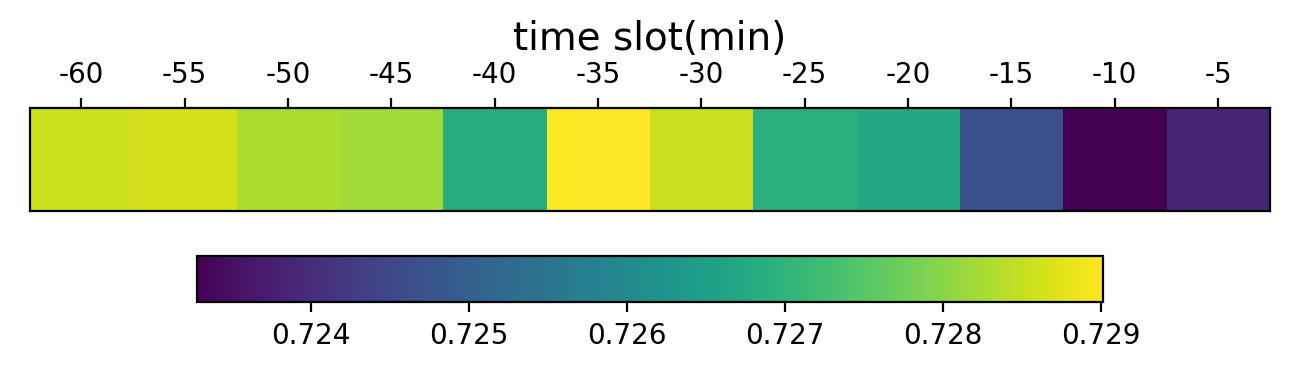

In [23]:
# print_array(fmask.T)
# print_array(fmask_grad.T)
print_array(np.mean(fmask,1).reshape(12,1).T,orientation= 'horizontal')
# print_mx(np.mean(fmask_grad,1).reshape(12,1).T)

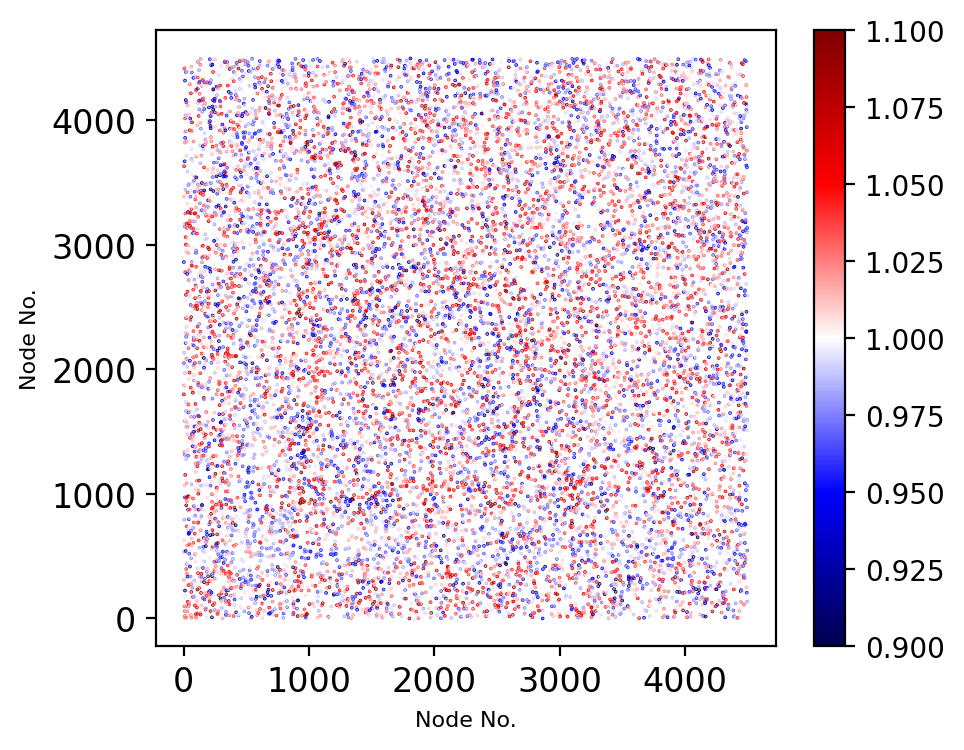

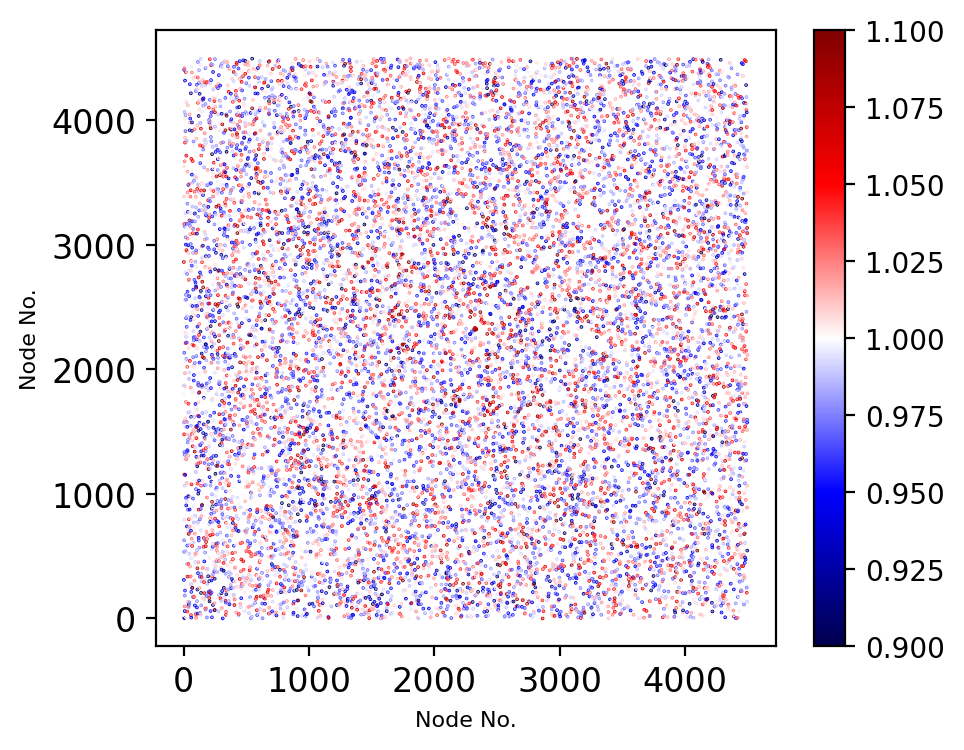

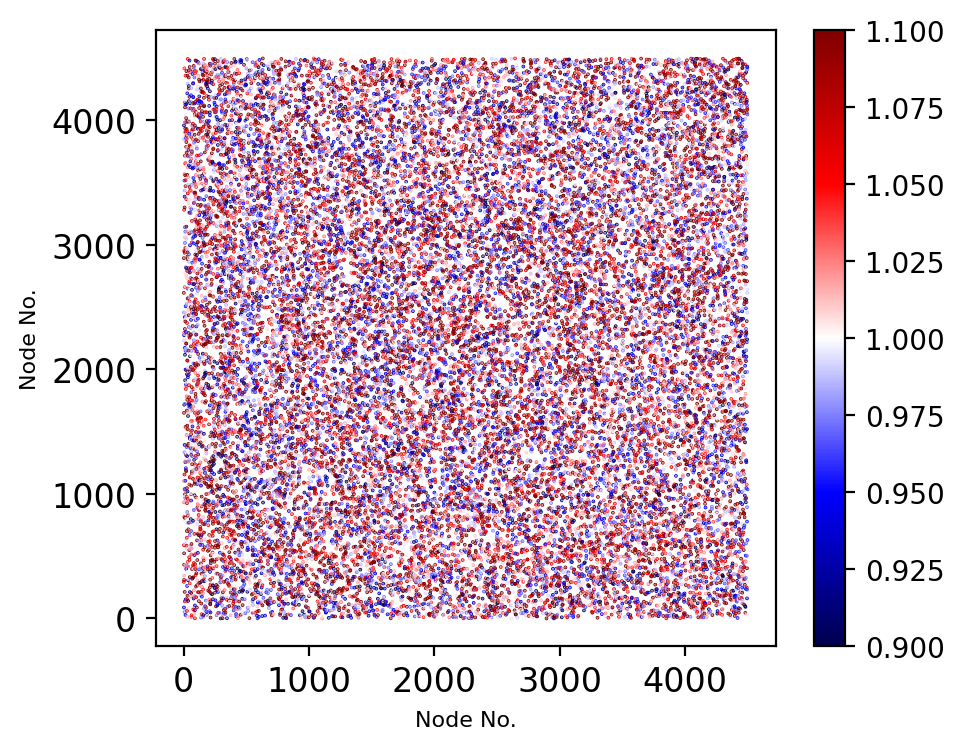

In [8]:
from copy import deepcopy
print_scatter('../img/mask1_mx.png',deepcopy(mask))
print_scatter('../img/mask2_mx.png',deepcopy(mask2))
print_scatter('../img/genmask_mx.png',deepcopy(gen_mask))

# 绘制mask频数分布

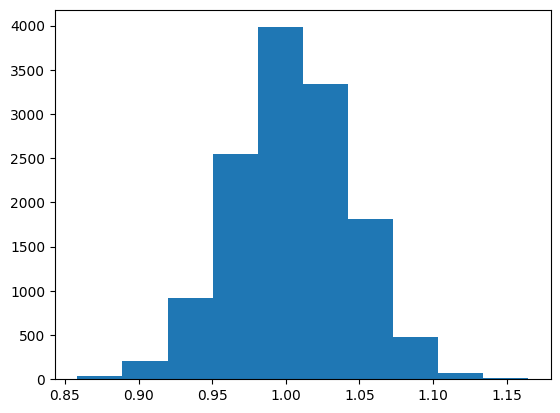

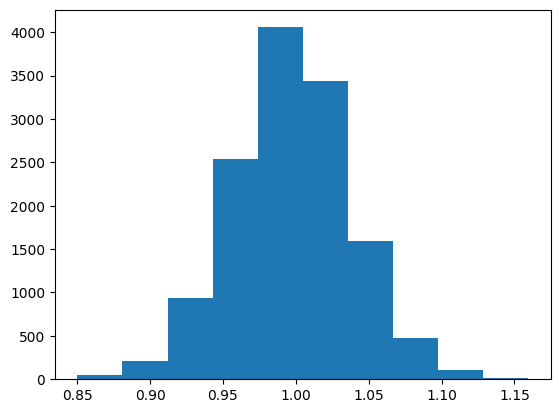

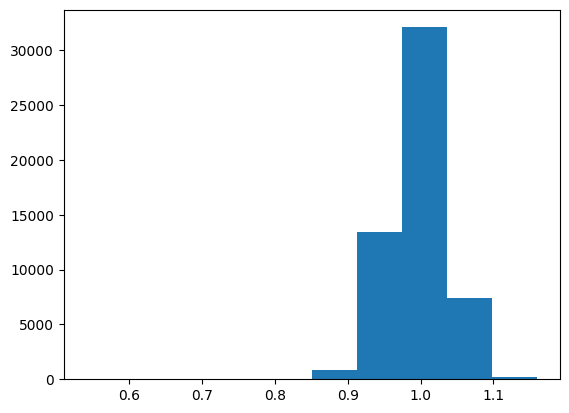

In [10]:
draw_distribute(mask)
draw_distribute(mask2)
draw_distribute(fmask)

# 绘制2D权重图

Progress: 100% |##############| Elapsed Time: 0:00:47 Time: 0:00:47 424.71 kB/s


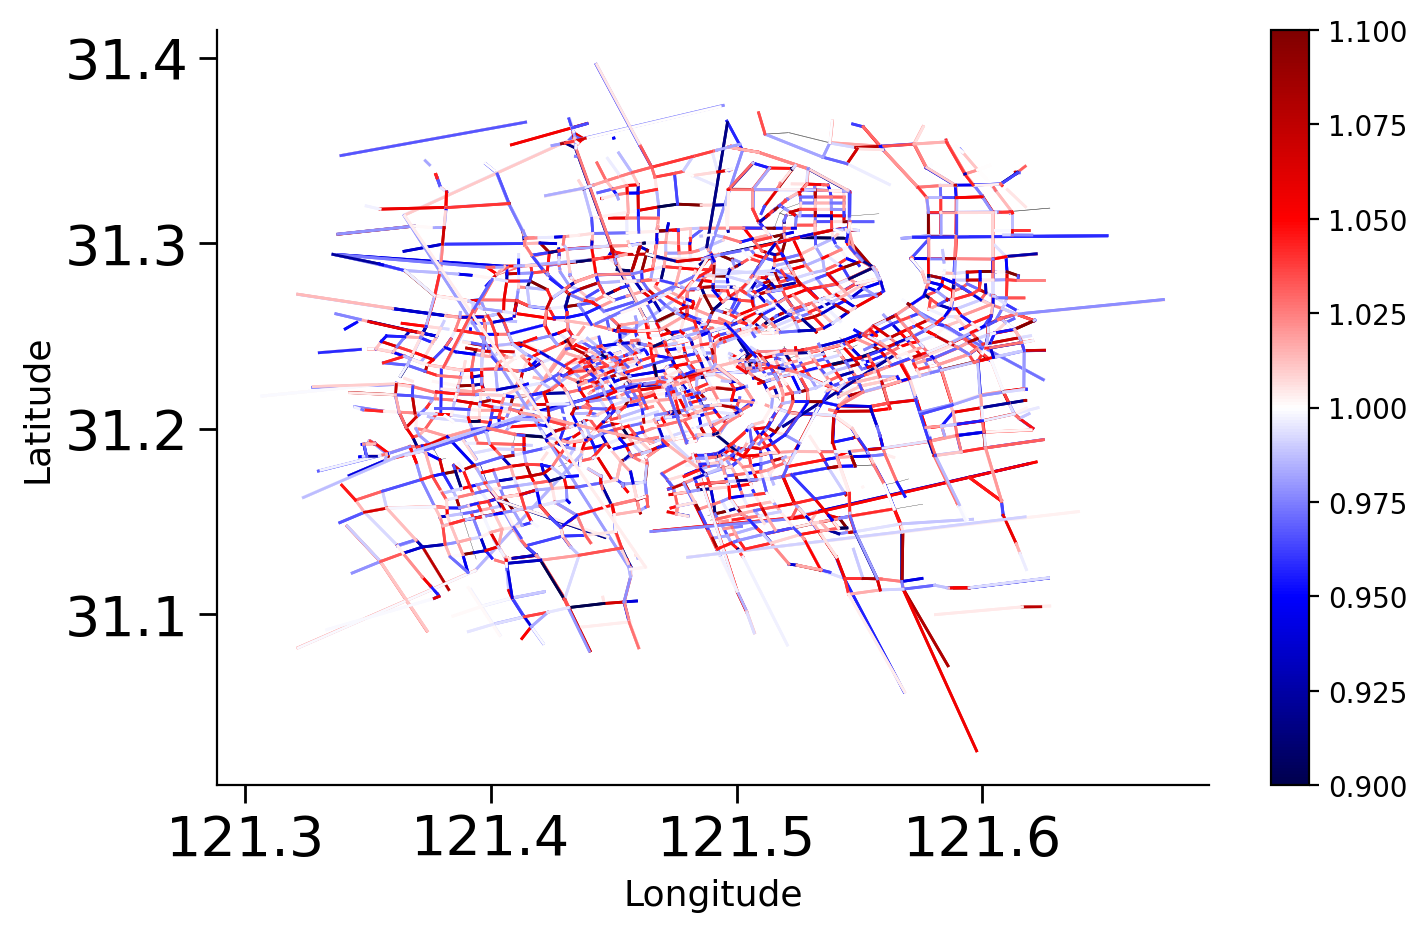

In [29]:
draw_matrix('../img/mask1.png',deepcopy(mask), graph, node_dict_amap, geo_ids)

Progress: 100% |##############| Elapsed Time: 0:00:41 Time: 0:00:41 488.65 kB/s


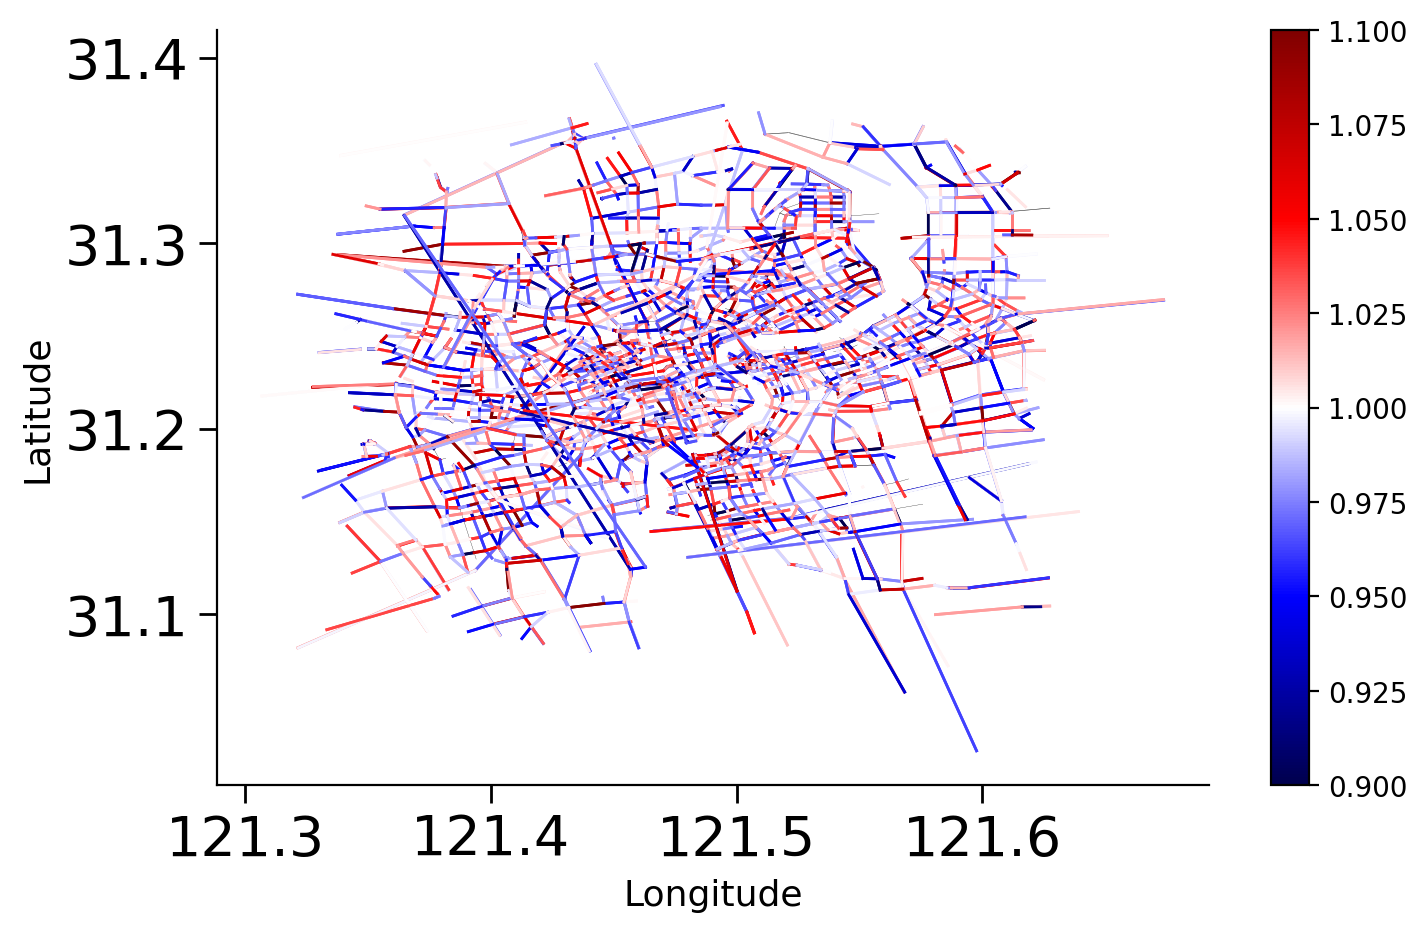

In [30]:
draw_matrix('../img/mask2.png',deepcopy(mask2), graph, node_dict_amap, geo_ids)

Progress: 100% |##############| Elapsed Time: 0:00:36 Time: 0:00:36 552.41 kB/s


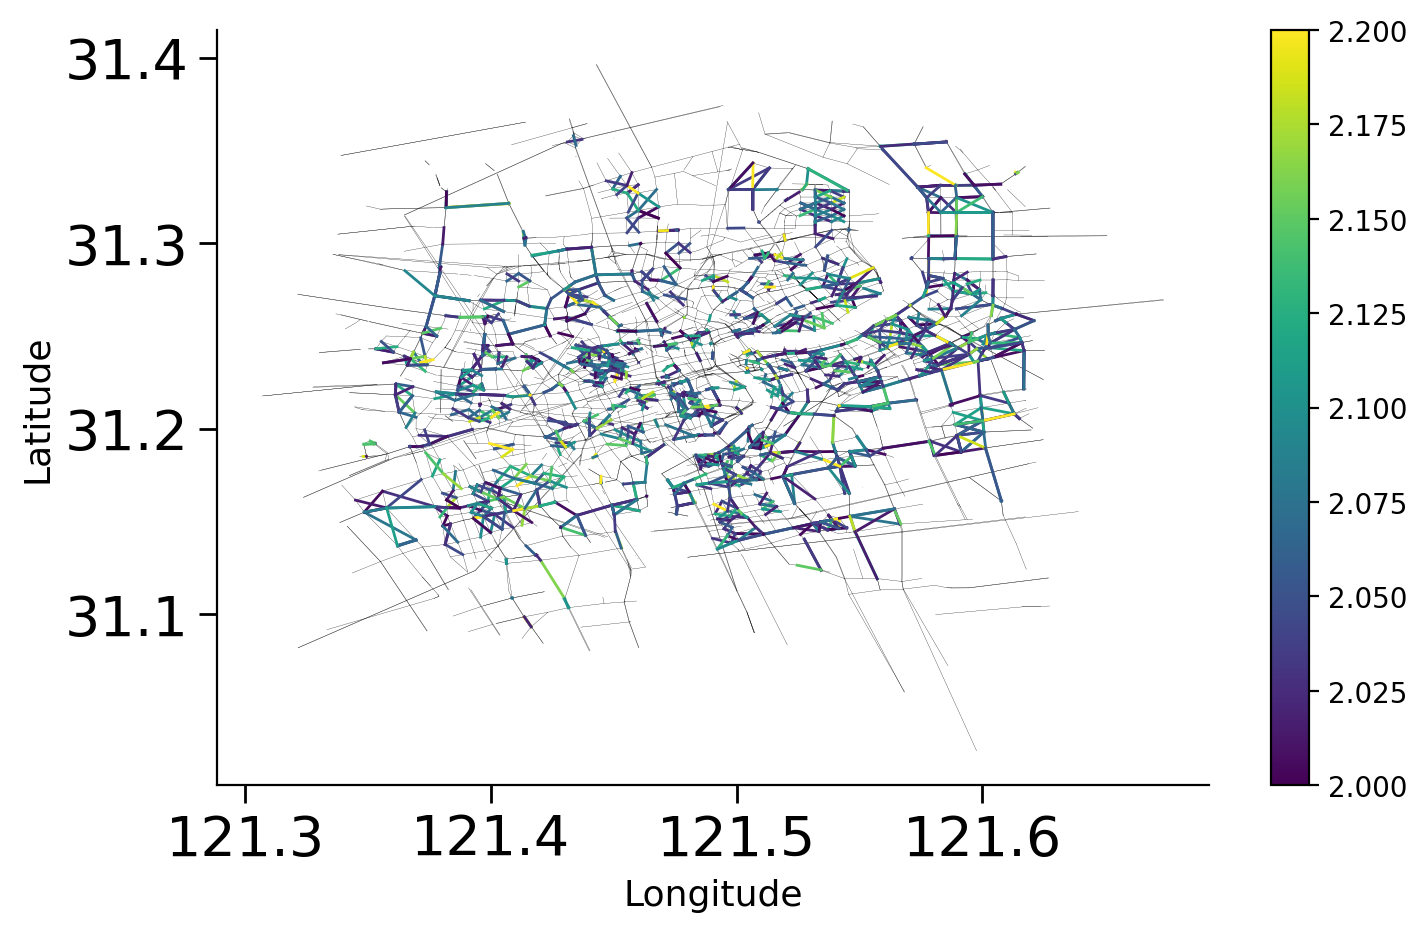

In [31]:
draw_matrix_btmlmt('../img/genmask.png',deepcopy(gen_mask), graph, node_dict_amap, geo_ids,t=2,h=2.2)

# 案例分析

In [33]:
import json
from matplotlib import cm,colors

maxium,minium=np.max(gen_mask),1
for e in gen_mask.flatten():
    if e!=0 and e<minium:
        minium=e       
cmap = cm.get_cmap('viridis', 10)

ref=node_dict

data=[]
for i in range(len(gen_mask)):
    for j in range(i,len(gen_mask)):
        if gen_mask[i][j]!=0:
            edge_msg={}
            vi = str(geo_ids[i])
            vj = str(geo_ids[j])
            color = cmap((gen_mask[i][j]-minium)/(maxium-minium))
            if (vi,vj) in edge_name:
                edge_msg['name'] = edge_name[(vi,vj)]
            else:
                edge_msg['name'] = '未知'
            edge_msg['color'] = color
            edge_msg['weight'] = float(gen_mask[i][j])
            edge_msg['path'] = [[float(ref[vi][0]), float(ref[vi][1])],[float(ref[vj][0]),float(ref[vj][1])]]
            data.append(edge_msg)
            
json = json.dumps(data, ensure_ascii=False)
with open('../data/lines.json','w') as f:
    f.write(json)

In [38]:
import panel as pn
import pydeck as pdk
import pandas as pd
from math import acos,cos,sin
pn.extension('deckgl')

MAPBOX_KEY = "KEY"

#裁剪区域
def distance(c1,c2):
    if c1==c2:
        return 0
    else:
        c1=(float(c1[0]),float(c1[1]))
        c2=(float(c2[0]),float(c2[1]))
        return 6371.004*acos(cos(c1[1])*cos(c2[1])*cos(c1[0]-c2[0])+sin(c1[1])*sin(c2[1]))

coord = [121.4382274,31.2265448]
r = 15
data = pd.read_json('../data/lines.json')
drop_list = []

for i in range(len(data['name'])):
    if distance(data['path'][i][0],coord) > r and distance(data['path'][i][1],coord) > r or data['weight'][i]<0.3:
        drop_list.append(i)
data = data.drop(data.index[drop_list])

json_spec = {
    "initialViewState": {
        "bearing": -27.36,
        "latitude": coord[1],
        "longitude": coord[0],
        "maxZoom": 20,
        "minZoom": 5,
        "pitch": 40.5,
        "zoom": 18
    },
    "layers": [{
        "@@type": "PathLayer",
        "data": data,
        "widthScale": 1,
        "getPath": "@@=path",
        "getWidth" : 5,
        "getColor" : "@@=[255 * color[0],255 * color[1],255 * color[2]]",
        "pickable": True,
        }
    ],
    # "mapStyle": "mapbox://styles/mapbox/dark-v9",
    "views": [
        {"@@type": "MapView", "controller": True}
    ]
}

deck_gl = pn.pane.DeckGL(json_spec, mapbox_api_key=MAPBOX_KEY, sizing_mode='stretch_width', height=600)

deck_gl

DeckGL(dict, height=600, mapbox_api_key='pk.eyJ1Ijoia29uZ2xpbmdodW..., sizing_mode='stretch_width')

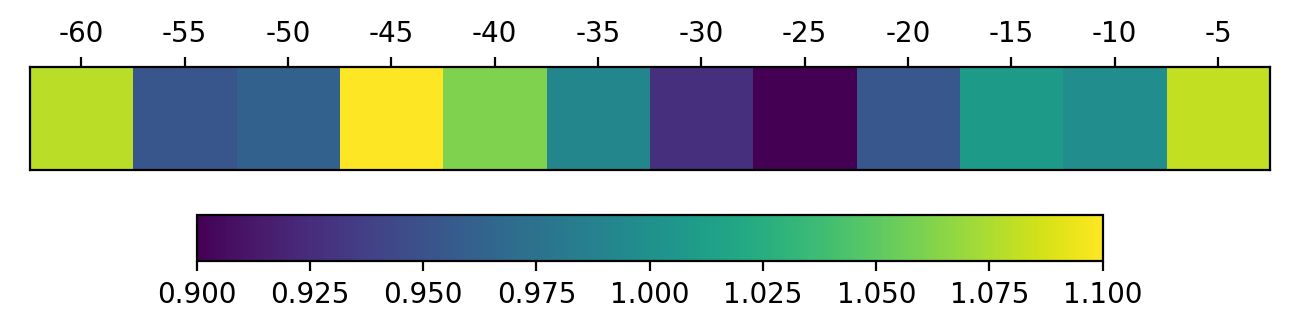

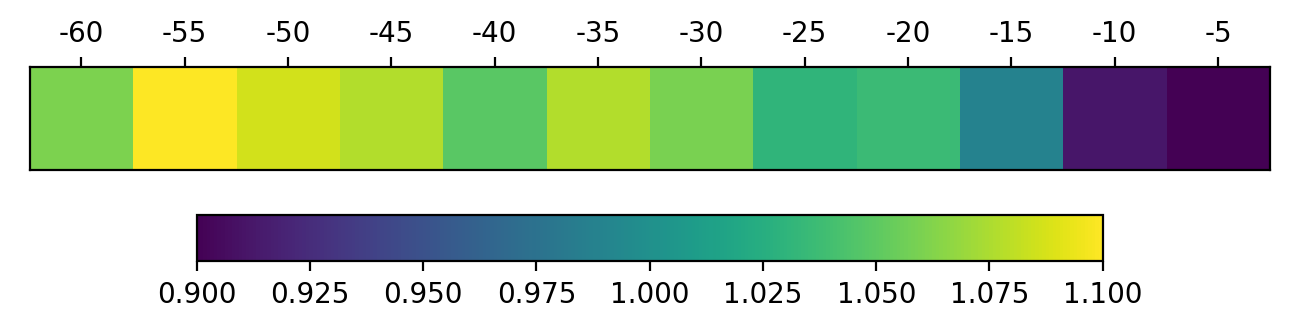

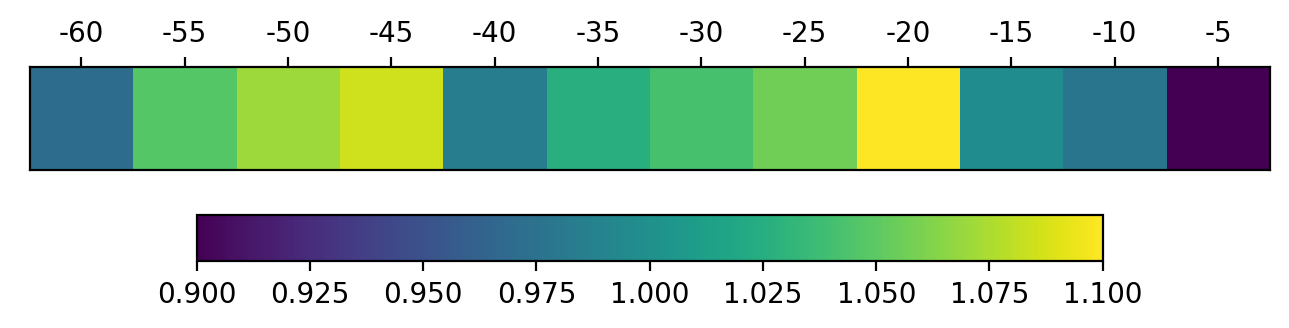

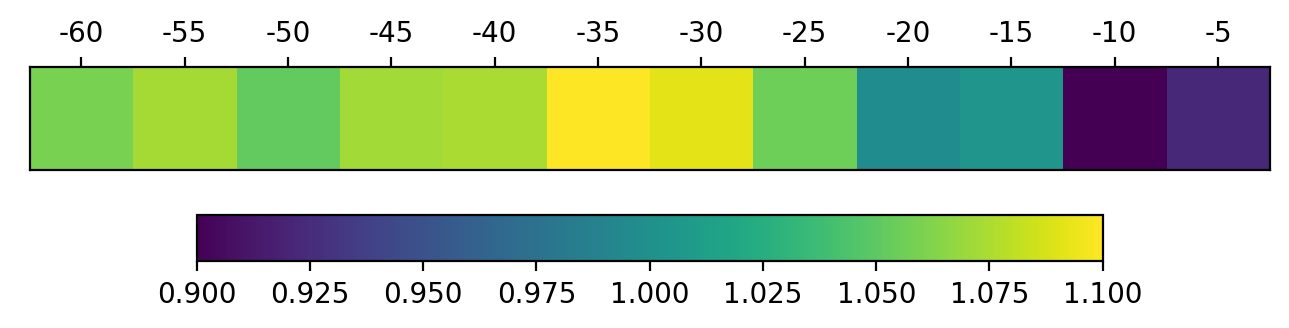

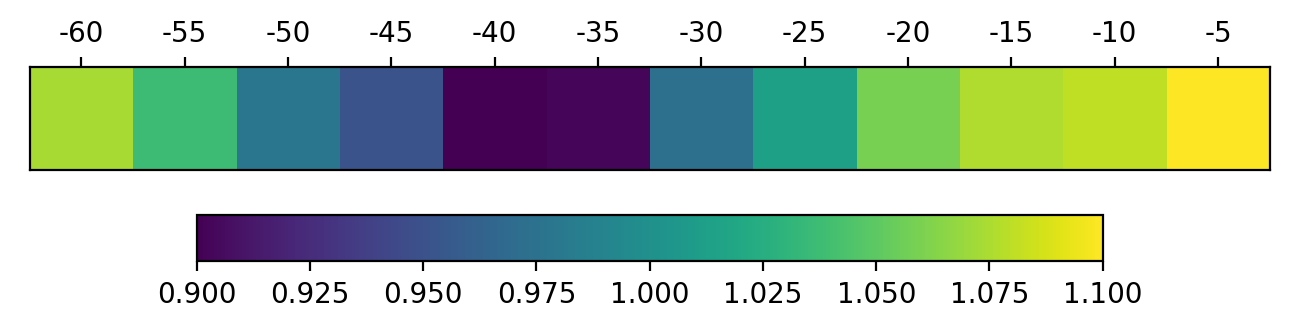

In [22]:
print_vector([(fmask.T[603]+fmask.T[3804])/2],'horizontal')
print_vector([fmask.T[2915]],'horizontal')
print_vector([(fmask.T[3394]+fmask.T[3327])/2],'horizontal')
print_vector([(fmask.T[2312]+fmask.T[1030])/2],'horizontal')
print_vector([fmask.T[3881]],'horizontal')